In [1]:
import numpy as np
from qiskit import QuantumCircuit, assemble, transpile
from qiskit import Aer # Simulator
from qiskit.visualization import plot_histogram

# The Bernstein-Vazirani Algorithm

In [2]:
def hadamard(circuit: QuantumCircuit, qubits: int):
    """
    Put all qubits in a superposition
    """
    for qubit in range(qubits):
        circuit.h(qubit)

def measure(circuit, qubits: int):
    """
    Measure all bits
    """
    for i in range(qubits):
        circuit.measure(i, i)

def simulate(circuit: QuantumCircuit):
    """
    Simulate the circuit and return the histogram
    """
    aer_sim = Aer.get_backend('aer_simulator')
    transpiled_dj_circuit = transpile(circuit, aer_sim)
    job = assemble(transpiled_dj_circuit)
    result = aer_sim.run(job).result()
    return result.get_counts()

Step 1: Put the initial state in a superposition
$$
H^{\otimes n} |x>_n = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} |x>_n
$$
Step 2: Call the subroutine that pefrorms the inner product with the unknown string
$$
U_f \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n} |x>_n = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{a\cdot x}|x>_n
$$
Step 3: Recover the unknown via interference
$$
H^{\otimes n} \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{a\cdot x}|x>_n = |a>_n
$$

In [3]:
def string_to_circuit(s: str):
    s = s[::-1] # reverse s to fit qiskit's qubit ordering
    n = len(s)
    oracle = QuantumCircuit(n+1)
    for q in range(n):
        if s[q] == '0':
            oracle.i(q)
        else:
            oracle.cx(q, n)
    return oracle

def bv_oracle(s: str):
    oracle = string_to_circuit(s)
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Inner Product"
    return oracle_gate

In [4]:
a = '1011'   # the hidden binary string
oracle = string_to_circuit(a)
oracle.draw()

q_0: ──■─────────────────
       │                 
q_1: ──┼─────────■───────
       │  ┌───┐  │       
q_2: ──┼──┤ I ├──┼───────
       │  └───┘  │       
q_3: ──┼─────────┼────■──
     ┌─┴─┐     ┌─┴─┐┌─┴─┐
q_4: ┤ X ├─────┤ X ├┤ X ├
     └───┘     └───┘└───┘

In [5]:
def build_circuit(oracle, n):
    bv_circuit = QuantumCircuit(n+1, n)

    # put auxiliary in state |->
    bv_circuit.h(n)
    bv_circuit.z(n)

    # Apply Hadamard gates before querying the oracle
    hadamard(bv_circuit, n)

    # Apply barrier
    bv_circuit.barrier()

    #introduce the oracle gate as a subroutine
    bv_circuit.append(oracle, range(n+1))

    # Apply barrier
    bv_circuit.barrier()

    #Apply Hadamard gates after querying the oracle
    hadamard(bv_circuit, n)

    # Measurement
    measure(bv_circuit, n)
    return bv_circuit

In [6]:
a = '101'   # the hidden binary string
n = len(a)
oracle = bv_oracle(a)
circuit = build_circuit(oracle, n)
circuit.draw()

┌───┐      ░ ┌────────────────┐ ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░─┤0               ├─░─┤ H ├┤M├──────
     ├───┤      ░ │                │ ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░─┤1               ├─░─┤ H ├─╫─┤M├───
     ├───┤      ░ │  Inner Product │ ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░─┤2               ├─░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ │                │ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤3               ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └────────────────┘ ░       ║  ║  ║ 
c: 3/════════════════════════════════════════╩══╩══╩═
                                             0  1  2

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(circuit, aer_sim)
job = assemble(transpiled_dj_circuit)
result = aer_sim.run(job).result()
answer = result.get_counts()

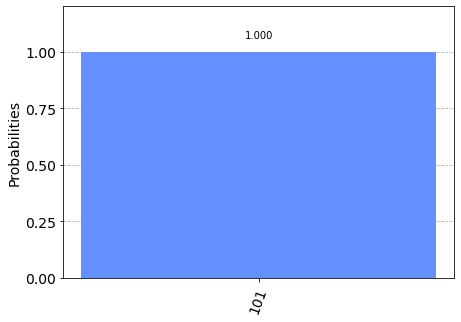

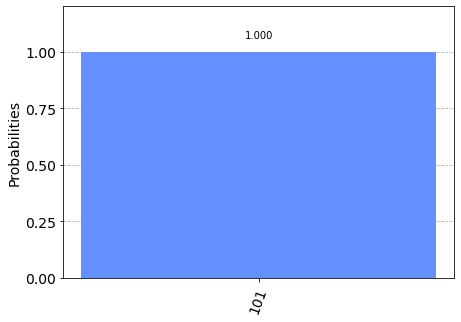

In [8]:
plot_histogram(answer)

In [9]:
a = '10100'   # the hidden binary string
n = len(a)
oracle = bv_oracle(a)
circuit = build_circuit(oracle, n)
circuit.draw()

┌───┐      ░ ┌────────────────┐ ░ ┌───┐┌─┐            
q_0: ┤ H ├──────░─┤0               ├─░─┤ H ├┤M├────────────
     ├───┤      ░ │                │ ░ ├───┤└╥┘┌─┐         
q_1: ┤ H ├──────░─┤1               ├─░─┤ H ├─╫─┤M├─────────
     ├───┤      ░ │                │ ░ ├───┤ ║ └╥┘┌─┐      
q_2: ┤ H ├──────░─┤2               ├─░─┤ H ├─╫──╫─┤M├──────
     ├───┤      ░ │  Inner Product │ ░ ├───┤ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├──────░─┤3               ├─░─┤ H ├─╫──╫──╫─┤M├───
     ├───┤      ░ │                │ ░ ├───┤ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├──────░─┤4               ├─░─┤ H ├─╫──╫──╫──╫─┤M├
     ├───┤┌───┐ ░ │                │ ░ └───┘ ║  ║  ║  ║ └╥┘
q_5: ┤ H ├┤ Z ├─░─┤5               ├─░───────╫──╫──╫──╫──╫─
     └───┘└───┘ ░ └────────────────┘ ░       ║  ║  ║  ║  ║ 
c: 5/════════════════════════════════════════╩══╩══╩══╩══╩═
                                             0  1  2  3  4

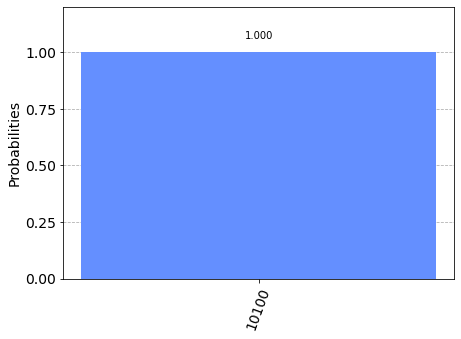

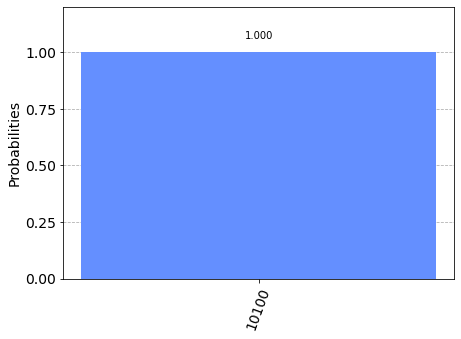

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(circuit, aer_sim)
job = assemble(transpiled_dj_circuit)
result = aer_sim.run(job).result()
answer = result.get_counts()
plot_histogram(answer)